In [1]:
from catboost import CatBoostClassifier, Pool, cv
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load Dataset

In [3]:
# 데이터 로드
df_trn = pd.read_csv('train.csv')
df_tst = pd.read_csv('test.csv')

In [4]:
df_trn.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,23,may,100,4,-1,0,unknown,0
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,20,may,172,1,-1,0,unknown,0
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,2,feb,56,1,-1,0,unknown,0
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,8,may,326,1,326,2,success,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,11,may,256,1,-1,0,unknown,0


In [5]:
df_tst.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,20,nov,101,2,-1,0,unknown,NaN
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,28,jan,156,2,-1,0,unknown,NaN
2,test00003,34,management,married,secondary,no,355,no,no,cellular,21,aug,314,3,-1,0,unknown,NaN
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,12,aug,940,10,-1,0,unknown,NaN
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,21,aug,252,4,-1,0,unknown,NaN


# 2. EDA

In [7]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         31647 non-null  object
 1   age        31647 non-null  int64 
 2   job        31647 non-null  object
 3   marital    31647 non-null  object
 4   education  31647 non-null  object
 5   default    31647 non-null  object
 6   balance    31647 non-null  int64 
 7   housing    31647 non-null  object
 8   loan       31647 non-null  object
 9   contact    31647 non-null  object
 10  day        31647 non-null  int64 
 11  month      31647 non-null  object
 12  duration   31647 non-null  int64 
 13  campaign   31647 non-null  int64 
 14  pdays      31647 non-null  int64 
 15  previous   31647 non-null  int64 
 16  poutcome   31647 non-null  object
 17  label      31647 non-null  int64 
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


In [8]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         13564 non-null  object 
 1   age        13564 non-null  int64  
 2   job        13564 non-null  object 
 3   marital    13564 non-null  object 
 4   education  13564 non-null  object 
 5   default    13564 non-null  object 
 6   balance    13564 non-null  int64  
 7   housing    13564 non-null  object 
 8   loan       13564 non-null  object 
 9   contact    13564 non-null  object 
 10  day        13564 non-null  int64  
 11  month      13564 non-null  object 
 12  duration   13564 non-null  int64  
 13  campaign   13564 non-null  int64  
 14  pdays      13564 non-null  int64  
 15  previous   13564 non-null  int64  
 16  poutcome   13564 non-null  object 
 17  label      0 non-null      float64
dtypes: float64(1), int64(7), object(10)
memory usage: 1.9+ MB


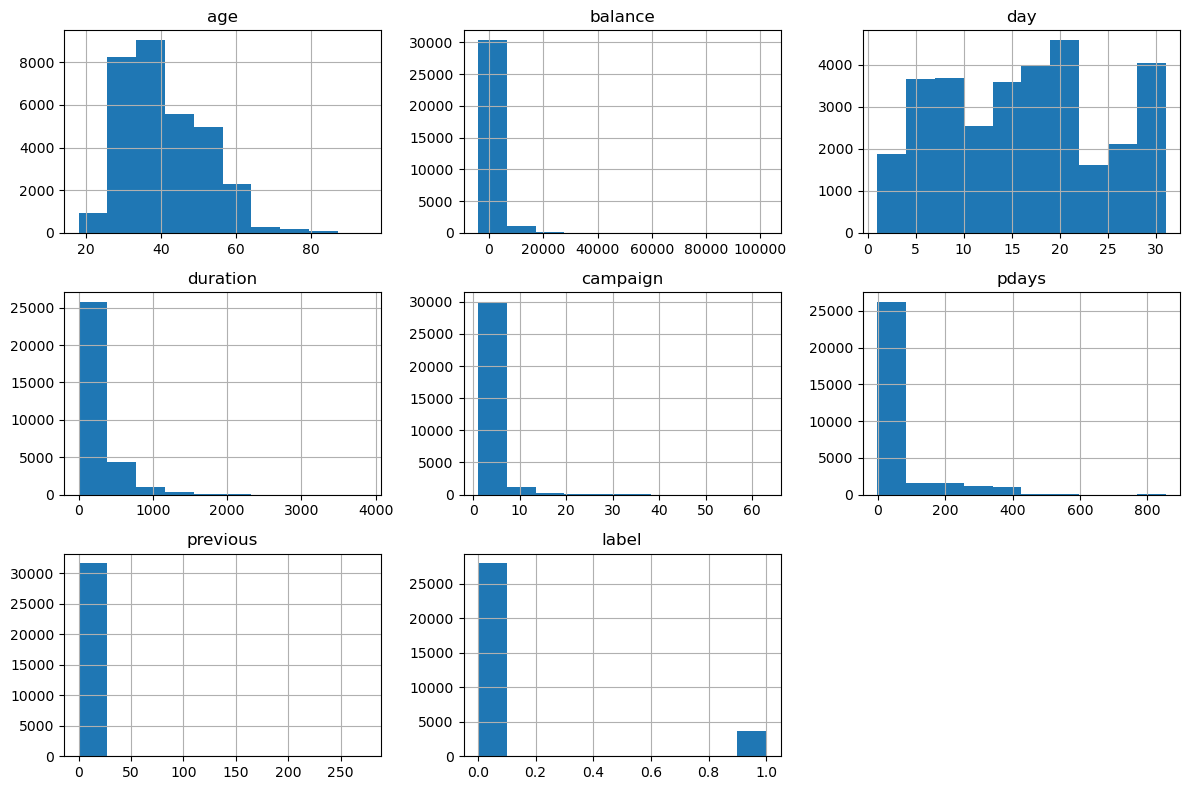

In [9]:
df_trn.hist(figsize=(12,8))
plt.tight_layout()

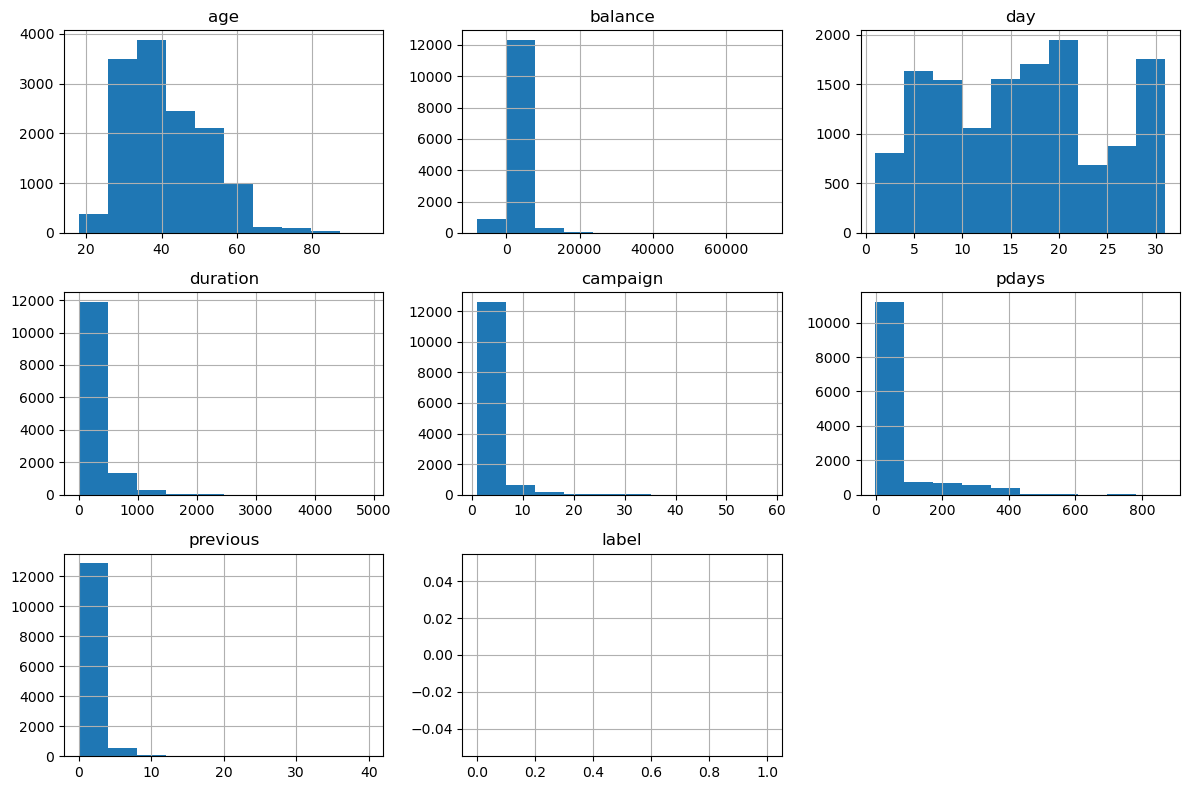

In [10]:
df_tst.hist(figsize=(12,8))
plt.tight_layout()

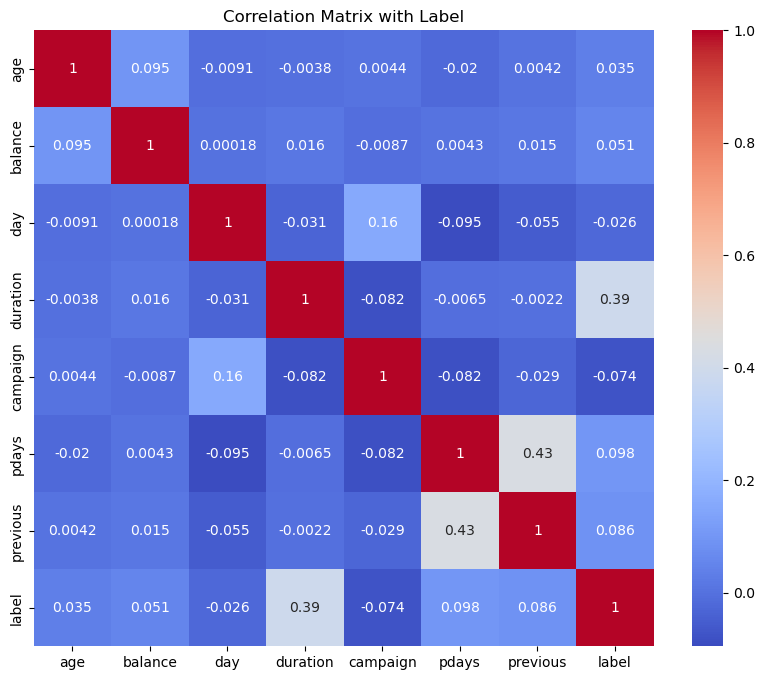

job: Chi-square=633.40, p-value=0.0000


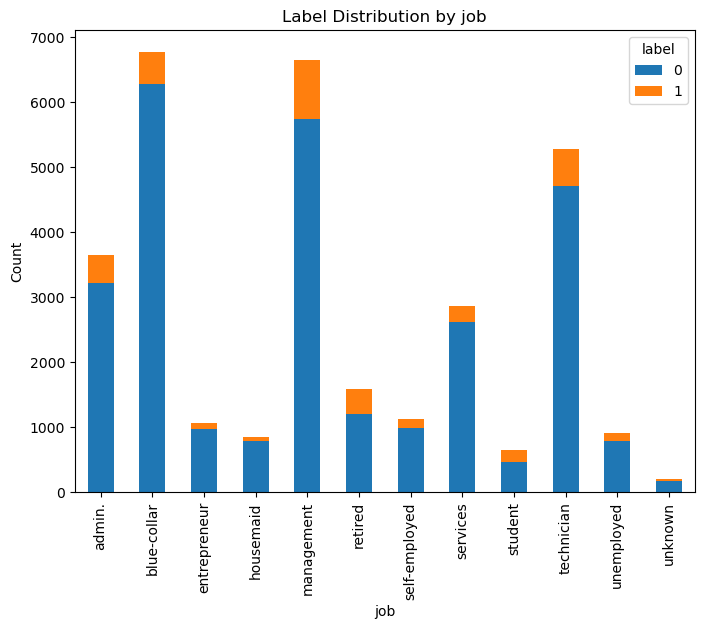

marital: Chi-square=105.98, p-value=0.0000


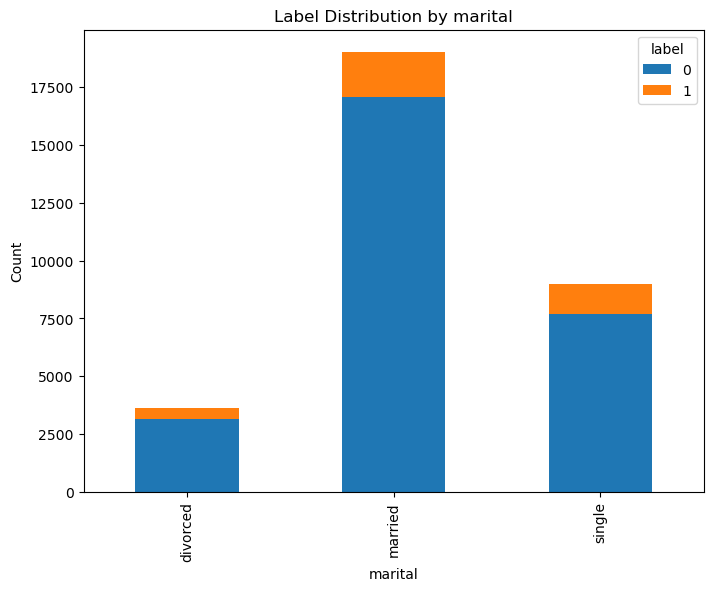

education: Chi-square=151.80, p-value=0.0000


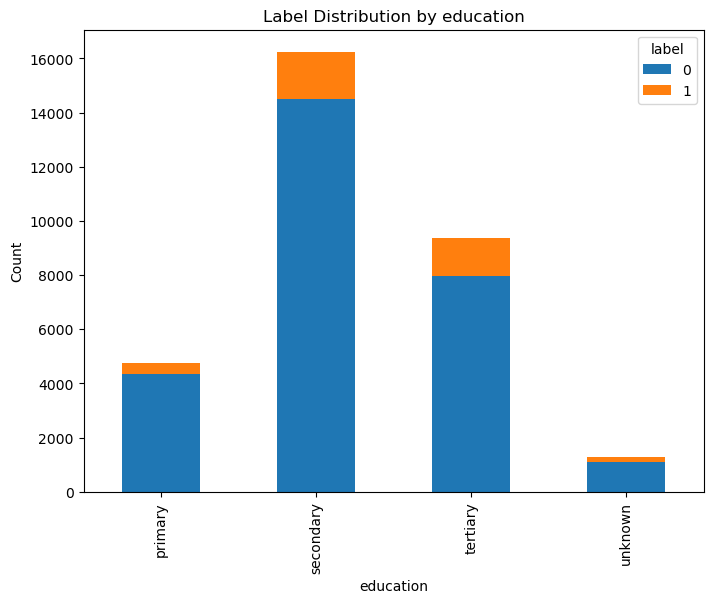

default: Chi-square=10.84, p-value=0.0010


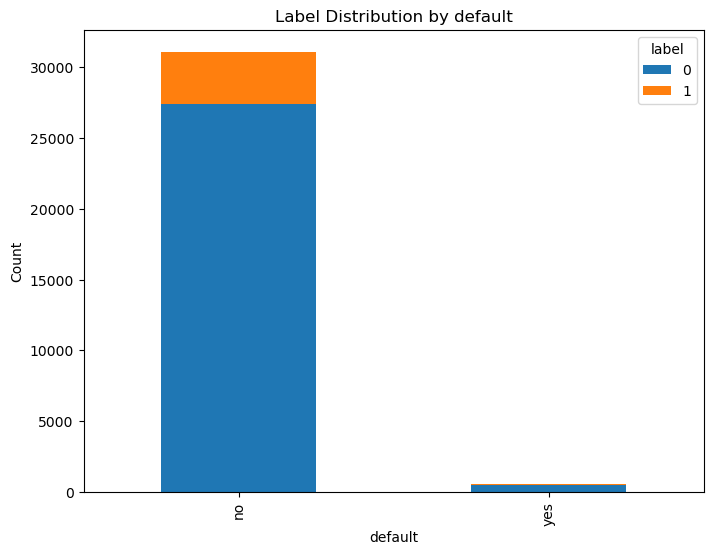

housing: Chi-square=644.91, p-value=0.0000


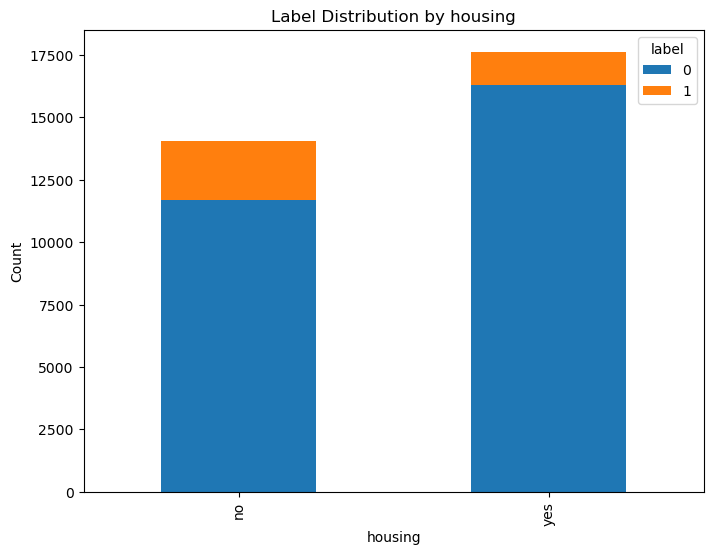

loan: Chi-square=141.77, p-value=0.0000


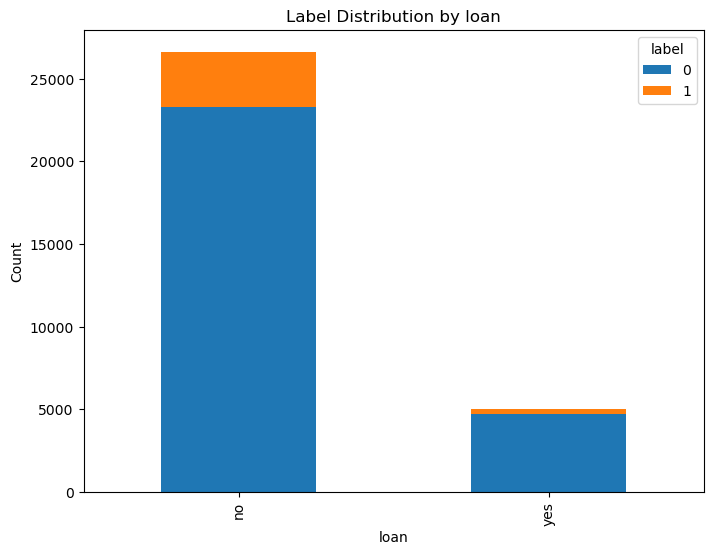

contact: Chi-square=705.71, p-value=0.0000


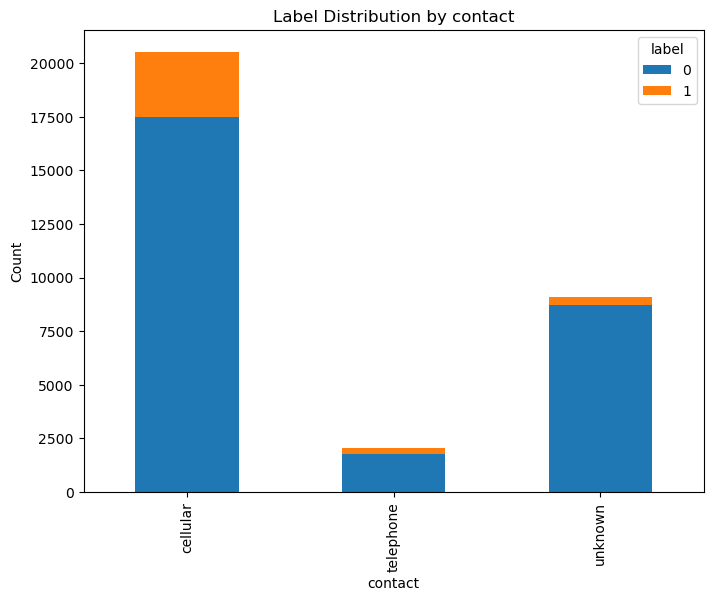

month: Chi-square=2149.51, p-value=0.0000


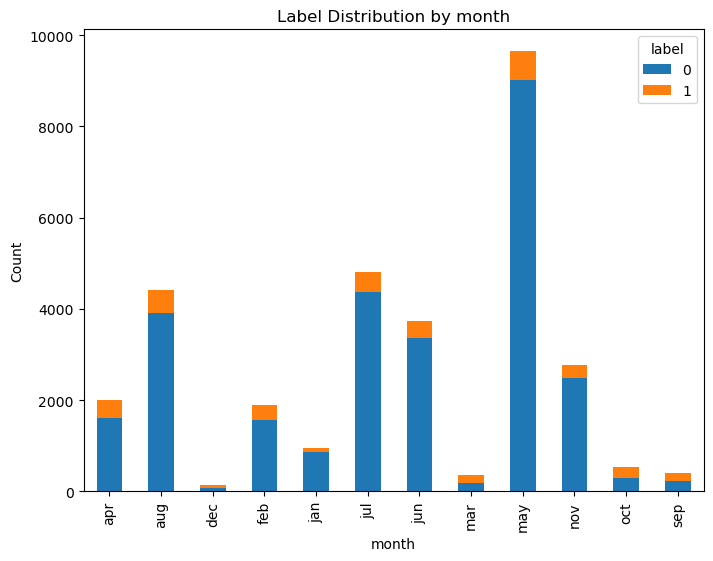

poutcome: Chi-square=3051.95, p-value=0.0000


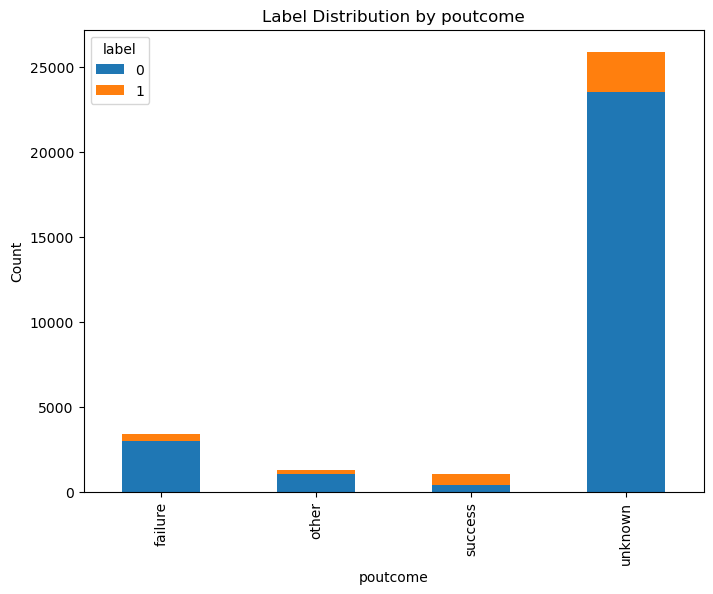

In [11]:
# 수치형 변수 상관계수 계산
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'label']
correlation_matrix = df_trn[numeric_columns].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix with Label")
plt.show()

# 범주형 변수와 label의 상관관계
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in categorical_columns:
    contingency_table = pd.crosstab(df_trn[col], df_trn['label'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"{col}: Chi-square={chi2:.2f}, p-value={p:.4f}")
    # 범주형 변수 시각화
    contingency_table.plot(kind="bar", stacked=True, figsize=(8, 6))
    plt.title(f"Label Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [12]:
# df_trn: 주어진 데이터프레임
df_trn['job_housing_loan'] = (
    df_trn['job'].astype(str) + "_" +
    df_trn['housing'].astype(str) + "_" +
    df_trn['loan'].astype(str)
)

df_trn['balance_positive'] = (df_trn['balance'] > 0).astype(int)
df_trn['long_duration'] = (df_trn['duration'] > df_trn['duration'].median()).astype(int)
df_trn['recent_contact'] = (df_trn['pdays'] <= 7).astype(int)

# 결과 확인
df_trn.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,duration,campaign,pdays,previous,poutcome,label,job_housing_loan,balance_positive,long_duration,recent_contact
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,...,100,4,-1,0,unknown,0,blue-collar_yes_no,1,0,1
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,...,172,1,-1,0,unknown,0,blue-collar_yes_no,0,0,1
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,...,56,1,-1,0,unknown,0,management_yes_no,1,0,1
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,...,326,1,326,2,success,0,blue-collar_yes_no,1,1,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,...,256,1,-1,0,unknown,0,housemaid_yes_no,1,1,1


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, pointbiserialr

# 데이터 로드 (예시: df_trn)
df = df_trn.copy()

# 1. 수치형 및 범주형 변수 구분
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. 수치형 변수와 `label` 간 상관관계 (Point-Biserial Correlation)
numeric_corr = {}
for col in numeric_cols:
    if col != 'label':
        corr, _ = pointbiserialr(df[col], df['label'])
        numeric_corr[col] = corr

# 3. 범주형 변수와 `label` 간 상관관계 (Cramér's V)
def cramers_v(confusion_matrix):
    """Cramér's V 계산 함수"""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)  # chi2 계산
    n = confusion_matrix.to_numpy().sum()  # 전체 표본 크기
    r, k = confusion_matrix.shape  # 행과 열 개수
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

categorical_corr = {}
for col in categorical_cols:
    try:
        confusion_matrix = pd.crosstab(df[col], df['label'])
        if confusion_matrix.size == 0:
            continue
        categorical_corr[col] = cramers_v(confusion_matrix)
    except Exception as e:
        print(f"Error processing {col}: {e}")

# 4. 상관관계 결과 정리
numeric_corr_df = pd.DataFrame(list(numeric_corr.items()), columns=['Variable', 'Correlation']).sort_values(by='Correlation', ascending=False)
categorical_corr_df = pd.DataFrame(list(categorical_corr.items()), columns=['Variable', 'Correlation']).sort_values(by='Correlation', ascending=False)

# 5. 결과 출력
print("\nNumerical Variables Correlation with Label:")
print(numeric_corr_df)

print("\nCategorical Variables Correlation with Label:")
print(categorical_corr_df)



Numerical Variables Correlation with Label:
   Variable  Correlation
3  duration     0.391085
5     pdays     0.097961
6  previous     0.086401
1   balance     0.051078
0       age     0.034886
2       day    -0.026003
4  campaign    -0.074137

Categorical Variables Correlation with Label:
            Variable  Correlation
0                 ID     1.000000
9           poutcome     0.310543
8              month     0.260617
10  job_housing_loan     0.209258
7            contact     0.149330
5            housing     0.142752
1                job     0.141473
3          education     0.069258
6               loan     0.066930
2            marital     0.057870
4            default     0.018507


In [14]:
# df_tst
df_tst['job_housing_loan'] = (
    df_tst['job'].astype(str) + "_" +
    df_tst['housing'].astype(str) + "_" +
    df_tst['loan'].astype(str)
)

# 테스트 데이터도 동일하게 적용
df_tst['balance_positive'] = (df_tst['balance'] > 0).astype(int)
df_tst['long_duration'] = (df_tst['duration'] > df_tst['duration'].median()).astype(int)
df_tst['recent_contact'] = (df_tst['pdays'] <= 7).astype(int)

# 결과 확인
df_tst.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,duration,campaign,pdays,previous,poutcome,label,job_housing_loan,balance_positive,long_duration,recent_contact
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,...,101,2,-1,0,unknown,NaN,management_no_no,1,0,1
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,...,156,2,-1,0,unknown,NaN,unemployed_no_no,1,0,1
2,test00003,34,management,married,secondary,no,355,no,no,cellular,...,314,3,-1,0,unknown,NaN,management_no_no,1,1,1
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,...,940,10,-1,0,unknown,NaN,management_no_no,1,1,1
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,...,252,4,-1,0,unknown,NaN,technician_no_no,1,1,1


In [16]:
# 1. 데이터 준비
id_cols = ['ID']
y_cols = ['label']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'job_housing_loan']
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'balance_positive', 'long_duration', 'recent_contact']

# 범주형 변수의 타입을 문자열로 변환
df_trn[cat_cols] = df_trn[cat_cols].astype(str)
df_tst[cat_cols] = df_tst[cat_cols].astype(str)

In [22]:
# 2. 로그 변환 함수 정의
def safe_log1p(x):
    return np.log1p(np.maximum(x, 1e-6))  # 음수 및 0 값 방지


In [23]:
# 3. 수치형 변수 전처리 파이프라인 구성
preprocessor = ColumnTransformer([
    ('num_pipeline', Pipeline([
        ('log_transform', FunctionTransformer(safe_log1p, validate=True)),
        ('scaler', StandardScaler())
    ]), num_cols)
], remainder='passthrough')

In [24]:
# 4. 데이터 전처리
X = df_trn.drop(columns=id_cols + y_cols)
y = df_trn[y_cols[0]]
X_tst = df_tst.drop(columns=id_cols)

# 수치형 변수 전처리 수행
X_trn_processed = preprocessor.fit_transform(X)
X_tst_processed = preprocessor.transform(X_tst)

# 전처리 후 DataFrame으로 복원 (수치형 + 범주형)
X_trn_processed = pd.DataFrame(X_trn_processed, columns=num_cols + cat_cols)
X_tst_processed = pd.DataFrame(X_tst_processed, columns=num_cols + cat_cols)

In [26]:
# 5. CatBoost 모델 설정
cat_features_indices = [X.columns.get_loc(c) for c in cat_cols]

In [27]:
# 수치형 변수의 타입을 float로 변환
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'balance_positive', 'long_duration', 'recent_contact']

# 수치형 변수 변환
for col in num_cols:
    X_trn_processed[col] = pd.to_numeric(X_trn_processed[col], errors='coerce')
    X_tst_processed[col] = pd.to_numeric(X_tst_processed[col], errors='coerce')

# 변환 후 확인
print(X_trn_processed.dtypes)


age                 float64
balance             float64
day                 float64
duration            float64
campaign            float64
pdays               float64
previous            float64
balance_positive    float64
long_duration       float64
recent_contact      float64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
poutcome             object
job_housing_loan     object
dtype: object


In [29]:
# 범주형 변수는 이미 문자열로 변환되었으므로 그대로 유지
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'job_housing_loan']

# 범주형 변수 인덱스 업데이트
cat_features_indices = [X_trn_processed.columns.get_loc(c) for c in cat_cols]

In [30]:
# NaN 값이 있는지 확인
print(X_trn_processed.isnull().sum())

# NaN 값 처리 (필요시 NaN을 'unknown'으로 대체)
X_trn_processed[cat_cols] = X_trn_processed[cat_cols].fillna('unknown')
X_tst_processed[cat_cols] = X_tst_processed[cat_cols].fillna('unknown')


age                 0
balance             0
day                 0
duration            0
campaign            0
pdays               0
previous            0
balance_positive    0
long_duration       0
recent_contact      0
job                 0
marital             0
education           0
default             0
housing             0
loan                0
contact             0
month               0
poutcome            0
job_housing_loan    0
dtype: int64


In [31]:
# 6. CatBoost 교차 검증 수행 (CV)
train_pool = Pool(X_trn_processed, y, cat_features=cat_features_indices)

cv_results = cv(
    train_pool,
    params={
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 8,
        'cat_features': cat_features_indices,
        'random_seed': 42,
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        'loss_function': 'Logloss',  # loss_function을 명시적으로 설정
        'verbose': False
    },
    fold_count=5,
    early_stopping_rounds=50
)

# F1-Score 출력
mean_f1_score = cv_results['test-F1-mean'].max()
print(f"Cross-validated Mean F1-Score: {mean_f1_score:.4f}")

Training on fold [0/5]

bestTest = 0.8672893522
bestIteration = 128

Training on fold [1/5]

bestTest = 0.8448118416
bestIteration = 2

Training on fold [2/5]

bestTest = 0.8748777747
bestIteration = 152

Training on fold [3/5]

bestTest = 0.8634942016
bestIteration = 66

Training on fold [4/5]

bestTest = 0.878108147
bestIteration = 286

Cross-validated Mean F1-Score: 0.8635


In [ ]:
# 최적의 F1-Score를 찾은 후, 사용한 하이퍼파라미터들을 그대로 사용
# 최적 threshold 계산 함수
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.0, 1.01, 0.01)
    best_threshold = 0.0
    best_f1 = 0.0
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# 교차 검증에서 사용한 하이퍼파라미터를 수동으로 지정
best_params = {
    'iterations': 1000,  # 사용한 하이퍼파라미터 값
    'learning_rate': 0.05,  # 사용한 하이퍼파라미터 값
    'depth': 8,  # 사용한 하이퍼파라미터 값
    'cat_features': cat_features_indices,
    'random_seed': 42,
    'eval_metric': 'F1',
    'loss_function': 'Logloss',
    'auto_class_weights': 'Balanced',
    'verbose': 100
}

cat_model = CatBoostClassifier(**best_params)
cat_model.fit(X_trn_processed, y, verbose=100, early_stopping_rounds=50)

# 훈련 데이터에 대한 예측 확률 계산
y_pred_proba_train = cat_model.predict_proba(X_trn_processed)[:, 1]

# 최적 threshold 계산
optimal_threshold, optimal_f1 = find_optimal_threshold(y, y_pred_proba_train)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"F1-Score at Optimal Threshold: {optimal_f1:.4f}")

0:	learn: 0.8188681	total: 71.1ms	remaining: 1m 11s
100:	learn: 0.8750874	total: 8.31s	remaining: 1m 13s
200:	learn: 0.8905561	total: 16.5s	remaining: 1m 5s
300:	learn: 0.9036567	total: 25.7s	remaining: 59.6s
400:	learn: 0.9133821	total: 35.1s	remaining: 52.4s
500:	learn: 0.9225510	total: 44.3s	remaining: 44.1s


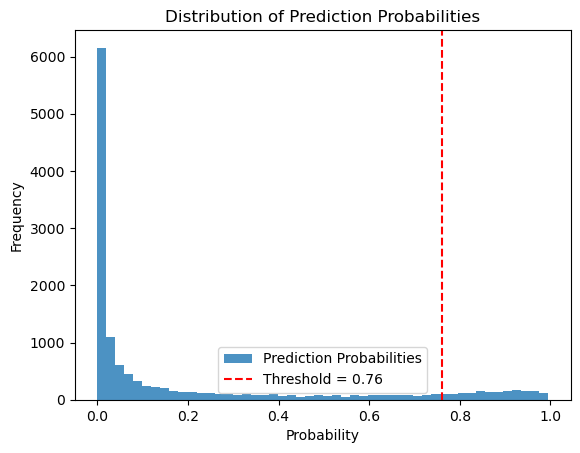

In [45]:
# 특정 임계값 이상에서만 1로 예측
threshold = 0.  # [수정] 임계값 설정 추가
y_pred = (y_pred_proba >= threshold).astype(int)

# 예측 확률 분포 시각화
plt.hist(y_pred_proba, bins=50, alpha=0.8, label="Prediction Probabilities")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")  # [수정] 확률 분포 시각화 추가
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [68]:
df_submission = pd.read_csv('submission_example.csv')
df_submission['label'] = y_pred

In [70]:
# 새로운 파일로 저장하기
filename = 'my_answer8.csv'
df_submission.to_csv(filename, index=False)